In [20]:
import sys
sys.path.append("../")
import wilds
from wilds.common.grouper import CombinatorialGrouper

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import torch
import seaborn as sns

sns.set_style("whitegrid")

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r"""
\usepackage{sansmath}
\sansmath
""" #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica, Avant Garde, Computer Modern Sans serif' # Choose a nice font here

fontsize = 15

In [2]:
def get_res(log_path, col_names):
    df = pd.read_csv(f"{log_path}/train_eval.csv")
    trn_res = df[col_names].values.tolist()[-1]
    df = pd.read_csv(f"{log_path}/test_eval.csv")
    tst_res = df[col_names].values.tolist()[-1]
    return trn_res, tst_res

In [3]:
ds_name = "celebA"

col_names = ['acc_y:notblond_male:0', 'acc_y:notblond_male:1', 'acc_y:blond_male:0', 'acc_y:blond_male:1']

data = {}
log_path = "./data/celebA/erm-resnet50"
data["ERM"] = np.concatenate(get_res(log_path, col_names))
log_path = "./data/celebA/iwerm-resnet50"
data["IWERM"] = np.concatenate(get_res(log_path, col_names))
log_path = "./data/celebA/erm-dp_resnet50-lr1e-3-dpsgd_1e-5_0.1_1.0_0.0001"
data["DP ERM"] = np.concatenate(get_res(log_path, col_names))
log_path = "./data/celebA/weightederm-dp_resnet50-dpsgd_1e-5_0.1_1.0_0.0001"
data["DP ERM IW"] = np.concatenate(get_res(log_path, col_names))

In [4]:
order = ['ERM', 'IWERM', 'DP ERM', 'DP ERM IW']
method = [(False, False), (True, False), (False, True), (True, True)]

data2 = {}
for j, k in enumerate(order):
    for i in [3]:
        hair = "not blond" if i < 2 else "blond"
        gender = "female" if (i % 2 == 0) else "male"
        
        data2[2*j] = (data[k][i], "train", hair, gender, method[j][0], method[j][1])
        data2[2*j+1] = (data[k][i+4], "test", hair, gender, method[j][0], method[j][1])
        
df = pd.DataFrame.from_dict(data2, orient="index", columns=["acc.", "split", "hair", "gender", "IW", "DP"])

In [6]:
df

,acc.,split,hair,gender,IW,DP
0,0.994232,train,blond,male,False,False
1,0.416667,test,blond,male,False,False
2,0.994232,train,blond,male,True,False
3,0.488889,test,blond,male,True,False
4,0.406205,train,blond,male,False,True
5,0.294444,test,blond,male,False,True
6,0.955347,train,blond,male,True,True
7,0.850000,test,blond,male,True,True


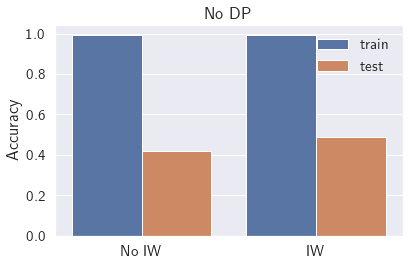

In [23]:
sns.set(font_scale=1.4)
g = sns.barplot(x="IW", y="acc.", hue="split", data=df[df['DP'] == False])
plt.legend(frameon=False)
g.set_title("No DP")
g.set_ylabel("Accuracy")
g.set_xlabel("")
g.set_xticklabels(['No IW', 'IW'])
plt.tight_layout()
plt.savefig("./figs/celebA_male_blond_nonDP.png")

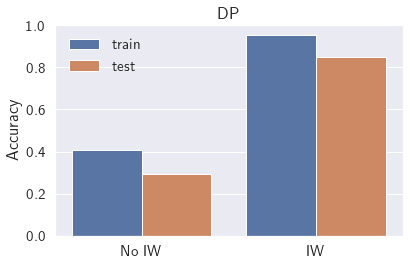

In [25]:
sns.set(font_scale=1.4)
g = sns.barplot(x="IW", y="acc.", hue="split", data=df[df['DP'] == True])
plt.legend(frameon=False)
g.set_title("DP")
g.set_ylabel("Accuracy")
g.set_xlabel("")
g.set_xticklabels(['No IW', 'IW'])
plt.tight_layout()
plt.savefig("./figs/celebA_male_blond_DP.png")

No handles with labels found to put in legend.


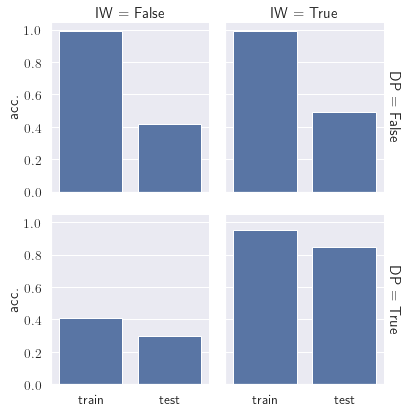

In [5]:
sns.set(font_scale=1.25)
g = sns.FacetGrid(df, col="IW", row="DP", margin_titles=True)
g.map_dataframe(sns.barplot, x="split", y="acc.")
#g.set_titles(fontsize=fontsize)
plt.legend(frameon=False)
g.set_xlabels("")
g.tight_layout()
plt.savefig("./figs/celebA_male_blond.png")